recon, mu, logvar = vae(input)

In [1]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from torch.utils.data import DataLoader
from gan_synthesis.datasets.dataset import Dataset
from torch import unique
dataset = Dataset()
loader = DataLoader(dataset, batch_size=369)

classes = 0
frequencies = {0: 0, 1: 0, 2: 0, 3: 0}
for _, seg in loader:
    uniques, counts = unique(seg, return_counts=True)
    print(counts)

weights = 1 / counts + 4e-6
class_weights = weights / weights.sum()

percents = counts / counts.sum()
print(percents)

tensor([2458239,  246423,  486903,  209139])
tensor([0.7229, 0.0725, 0.1432, 0.0615])


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from gan_synthesis.mask_vae_models.vae import VAE, dice_loss_mc_opts, kl_divergence_capacity, kl_divergence
from gan_synthesis.mask_vae_models.chat_model import VAE1
from gan_synthesis.datasets.dataset import Dataset
from tqdm import tqdm

# Instantiate data loaders
dataset = Dataset()
train_set, test_set = dataset.split(0.95)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

# Instantiate models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE(size=96, latent_dim=32).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss(weight=dataset.weights.to(device))

# Before the loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
ce_losses = []

# final_z = torch.zeros(shape=)
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    running_kld_loss = 0.0
    running_ce_loss = 0.0
    running_dice_loss = 0.0

    # if epoch == 499:
    #     with torch.no_grad():
    #         recon, mu, logvar = model(seg_input)


    # if epoch % 10 == 0 and epoch != 0:
    #     with torch.no_grad:
    #         recon, mu, logvar = model

    for _, seg in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
        correct, total = 0, 0
        seg_input = seg.to(torch.float32).to(device)
        seg_target = seg.squeeze(1).long().to(device)

        recon, mu, logvar = model(seg_input)
        # if epoch == 499:
        #     with torch.no_grad():
        # kld = kl_divergence(mu, logvar)
        # print(kld, kld.shape)
        kld_loss = kl_divergence_capacity(mu, logvar, epoch=epoch, beta=1, max_capacity=50)
        ce_loss = criterion(recon, seg_target)
        dice_loss = dice_loss_mc_opts(recon, seg_target, ignore_bg=True)
        loss = ce_loss + kld_loss + 0.5 * dice_loss

        pred = torch.argmax(recon, dim=1)
        correct += (pred == seg_target).sum().item()
        total += seg.numel()

        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        running_kld_loss += kld_loss
        running_ce_loss += ce_loss
        running_dice_loss += dice_loss
        running_train_loss += loss.item()
    
    

    avg_train_loss = running_train_loss / len(train_loader)
    avg_kld_loss = running_kld_loss / len(train_loader)
    avg_ce_loss = running_ce_loss / len(train_loader)
    avg_dice_loss = running_dice_loss / len(train_loader)
    ce_losses.append(avg_ce_loss.item())
    train_losses.append(avg_train_loss)

    acc = correct / total
    train_accuracies.append(acc)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for _, seg in tqdm(test_loader, desc="Test", leave=False):
            seg_input = seg.to(torch.float32).to(device)
            seg_target = seg.squeeze(1).long().to(device)
            recon, mu, logvar = model(seg_input)
            kld_loss = kl_divergence_capacity(mu, logvar, epoch=epoch, beta=1, max_capacity=50)
            ce_loss = criterion(recon, seg_target)
            dice_loss = dice_loss_mc_opts(recon, seg_target, ignore_bg=True)
            loss = ce_loss + 0.5 * dice_loss + kld_loss
            running_val_loss += loss.item()

            pred = torch.argmax(recon, dim=1)
            correct += (pred == seg_target).sum().item()
            total += seg.numel()

    avg_val_loss = running_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    acc = correct / total
    val_accuracies.append(acc)

    # print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, KLD Train Loss: {avg_kld_loss:.4f}, CE Train Loss: {avg_ce_loss:.4f}, Dice Train Loss: {avg_dice_loss:.4f}\
    #         \nVal Loss: {avg_val_loss:.4f}, Val Acc: {acc:.4f}")


Epoch 1:  18%|█▊        | 2/11 [00:00<00:00, 16.95it/s]

KeyboardInterrupt: 

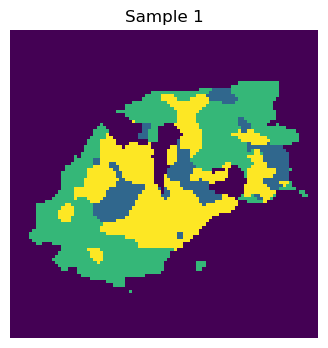

In [67]:
import matplotlib.pyplot as plt
image = model.sample(1, mode="argmax")


In [3]:
from random import randint
import numpy as np
import matplotlib.pyplot as plt
from gan_synthesis.preprocessing.transforms import read_cropped

def random_recon(model):
    num = randint(0, 368)
    image = read_cropped(idx=num, t="seg", as_type='pt').unsqueeze(0)
    seg_input = image.to(torch.float32).to("cuda")
    model.eval()
    with torch.no_grad():
        recon, mu, logvar = model(seg_input)
    
    recon = recon.argmax(dim=1)

    plt.imshow(image.squeeze().cpu().numpy())
    plt.show()
    plt.imshow(recon.squeeze().cpu().numpy())
    plt.show()
    

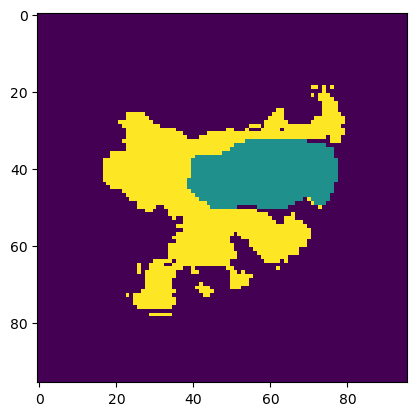

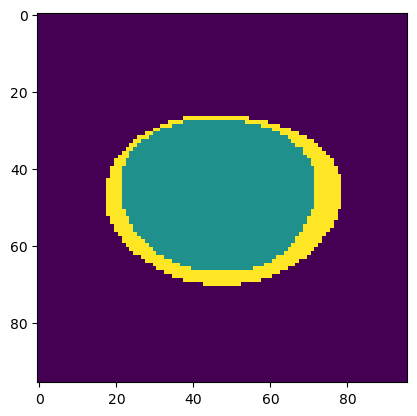

In [36]:
random_recon(model)

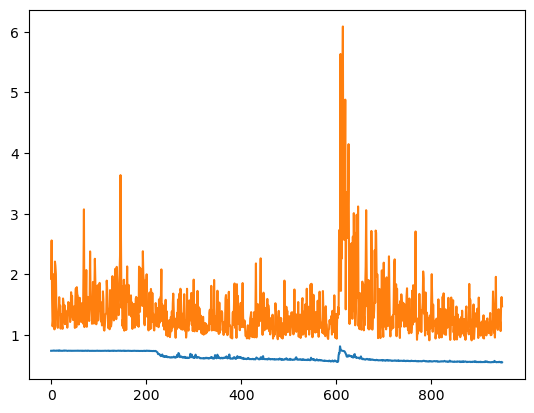

In [7]:
import matplotlib.pyplot as plt


plt.plot(ce_losses[50:])
plt.plot(val_losses[50:])
plt.show()

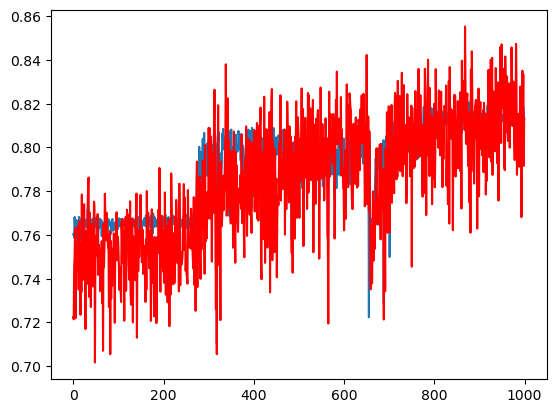

In [5]:
plt.plot(val_accuracies)
plt.plot(train_accuracies, 'r')
plt.show()